In [ ]:
# Open TOPCAT
# Look for tables, check schema. SSA Service
# init git
# refactor in a module with commits
# configure ruff and autosave
# packaging
# precommit
# add tests with coverage
# add docs
# ci/cd with github actions

# Data retrieval


In [4]:
import pandas as pd
from astroquery.utils.tap.core import TapPlus

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [ ]:
# Connect to the TAP service
tap = TapPlus(url="http://tap.roe.ac.uk/ssa")

adql = """
SELECT TOP 1000
    z.*,
    p.*
FROM BestDR9.ZooSpec AS z
JOIN BestDR7.PhotoObj AS p
  ON p.objid = z.dr7objid
"""

# Run synchronously
job = tap.launch_job(adql)
results = job.get_results()
df = results.to_pandas()

In [ ]:
def safe_to_numeric(col):
    try:
        return pd.to_numeric(col, errors="raise")
    except Exception:
        return col  # leave unchanged if it can't be fully parsed


df = df.apply(safe_to_numeric).set_index("dr7objid")

# Data filtering


In [10]:
mask = (
    # correct magnitudes
    (df["modelMag_u"] > -30)
    & (df["modelMag_g"] > -30)
    & (df["modelMag_r"] > -30)
    & (df["modelMag_i"] > -30)
    & (df["modelMag_z"] > -30)
    &
    # reasonable errors
    (df["modelMagErr_u"] < 0.5)
    & (df["modelMagErr_g"] < 0.05)
    & (df["modelMagErr_r"] < 0.05)
    & (df["modelMagErr_i"] < 0.05)
    & (df["modelMagErr_z"] < 0.1)
    &
    # very certain about the classification
    ((df["p_cs_debiased"] >= 0.9) | (df["p_el_debiased"] >= 0.9))
    &
    # medium size
    (df["petroR90_r"] * 2 * 1.5 / 0.4 < 64)
    & (df["petroR90_r"] * 2 / 0.4 > 20)
)

In [ ]:
cols_to_keep = (
    [
        "specobjid",
        "objid",
        "dr7objid",
        "ra",
        "dec",
        "p_el_debiased",
        "p_cs_debiased",
        "spiral",
        "elliptical",
    ]
    + ["petroR50_r", "petroR90_r"]
    + [f"modelMag_{f}" for f in "ugriz"]
    + [f"extinction_{f}" for f in "ugriz"]
)
df_filtered = df[mask][cols_to_keep]

In [15]:
df_filtered.head()

,specobjid,objid,ra,dec,p_el_debiased,p_cs_debiased,spiral,elliptical,petroR50_r,petroR90_r,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
dr7objid,,,,,,,,,,,,,,,,,,,,
587727178453221476,736367437259237376,1237652629102330052,8.749250,-10.632944,0.952,0.000,0,1,2.399796,7.172555,19.618238,17.803905,16.872460,16.450287,16.110678,0.132910,0.097794,0.070928,0.053783,0.038133
587724234249732168,473021753409431552,1237653653451243695,13.510292,16.051027,0.034,0.931,1,0,3.011557,7.503058,20.371210,18.590820,17.520271,16.965120,16.516520,0.432552,0.318267,0.230834,0.175034,0.124102
587724197740085400,472936541258278912,1237649918964990171,13.233209,14.169889,0.930,0.018,0,1,1.640008,4.498993,18.879148,17.071806,16.211632,16.047989,15.450515,0.316053,0.232549,0.168664,0.127893,0.090678
587724197203607681,472878816897820672,1237649918428512376,14.133875,13.698500,0.020,0.980,1,0,2.327382,7.055522,19.535625,17.923246,17.049698,16.570343,16.219820,0.358754,0.263968,0.191452,0.145172,0.102929
587724197202493564,471775455989491712,1237649918427398296,11.484458,13.812139,0.009,0.991,1,0,3.511922,7.065475,18.758015,17.559830,16.959278,16.575110,16.325520,0.401312,0.295282,0.214163,0.162393,0.115139


# Image cutout


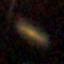

In [18]:
import urllib

from IPython.display import Image, display


IMAGE_PIXSCALE = 0.4  # arcsec/pixel
IMAGE_SIZE_PX = 64
IMAGE_WIDTH_PX = IMAGE_SIZE_PX
IMAGE_HEIGHT_PX = IMAGE_SIZE_PX
OBJECT_INDEX = 15  # which object from the filtered list to download

URL = (
    "https://skyserver.sdss.org/DR19/SkyserverWS/ImgCutout/getjpeg?"
    "ra={ra}&dec={dec}&scale={scale}&width={width}&height={height}"
)

RA = df_filtered.iloc[OBJECT_INDEX]["ra"]
DEC = df_filtered.iloc[OBJECT_INDEX]["dec"]


url = URL.format(ra=RA, dec=DEC, scale=IMAGE_PIXSCALE, width=IMAGE_WIDTH_PX, height=IMAGE_HEIGHT_PX)
response = urllib.request.urlopen(url)
blob = response.read()  # bytes of the image (JPEG)
display(Image(blob))